In [1]:
import h5py
import numpy as np

# Path to your HDF5 file
file_path = '5G_dataset/5G_training_data.hdf5'

# Create an empty dictionary to store NumPy arrays
data_dict = {}

# Open the HDF5 file
with h5py.File(file_path, 'r') as hdf:
    # Iterate over all datasets in the file
    for key in hdf.keys():
        dataset = hdf[key][:]
        data_dict[key] = dataset  # Store each dataset into the dictionary

# Now, you can access individual datasets as NumPy arrays
A_ID = data_dict['A_ID']
B_ID = data_dict['B_ID']
CIR_I = data_dict['CIR_I']
CIR_R = data_dict['CIR_R']
POS_X = data_dict['POS_X']
POS_Y = data_dict['POS_Y']
TD = data_dict['TD']
TD_OFFSET = data_dict['TD_OFFSET']
TIME_STAMP = data_dict['TIME_STAMP']

# For verification, print shapes of arrays
for key, value in data_dict.items():
    print(f"{key} shape: {value.shape}")

A_ID shape: (113203,)
B_ID shape: (113203,)
CIR_I shape: (113203, 128)
CIR_R shape: (113203, 128)
POS_X shape: (113203,)
POS_Y shape: (113203,)
TD shape: (113203,)
TD_OFFSET shape: (113203,)
TIME_STAMP shape: (113203,)


In [2]:
CIR=CIR_R+ 1j*CIR_I

In [3]:
grt_pos=np.stack((POS_X, POS_Y), axis=1)

In [4]:
def feature_extraction_F1(cir_matrix):
    R = cir_matrix * np.conj(cir_matrix)
    r = R.flatten()
    r_real = np.real(r)
    r_imag = np.imag(r)
    r_R = np.concatenate((r_real, r_imag))
    feature_vector = r_R / np.linalg.norm(r_R)
    return feature_vector

features_F1_cir = np.array([feature_extraction_F1(cir) for cir in CIR])
print("Shape of Features (F1_cir):", features_F1_cir.shape)

Shape of Features (F1_cir): (113203, 256)


In [5]:
from sklearn.model_selection import train_test_split
X_train, x1, y_train, y1 = train_test_split(features_F1_cir, grt_pos, test_size=0.4, random_state=42)
X_test, X_pred, y_test, y_pred = train_test_split(x1, y1, test_size=0.5, random_state=42)

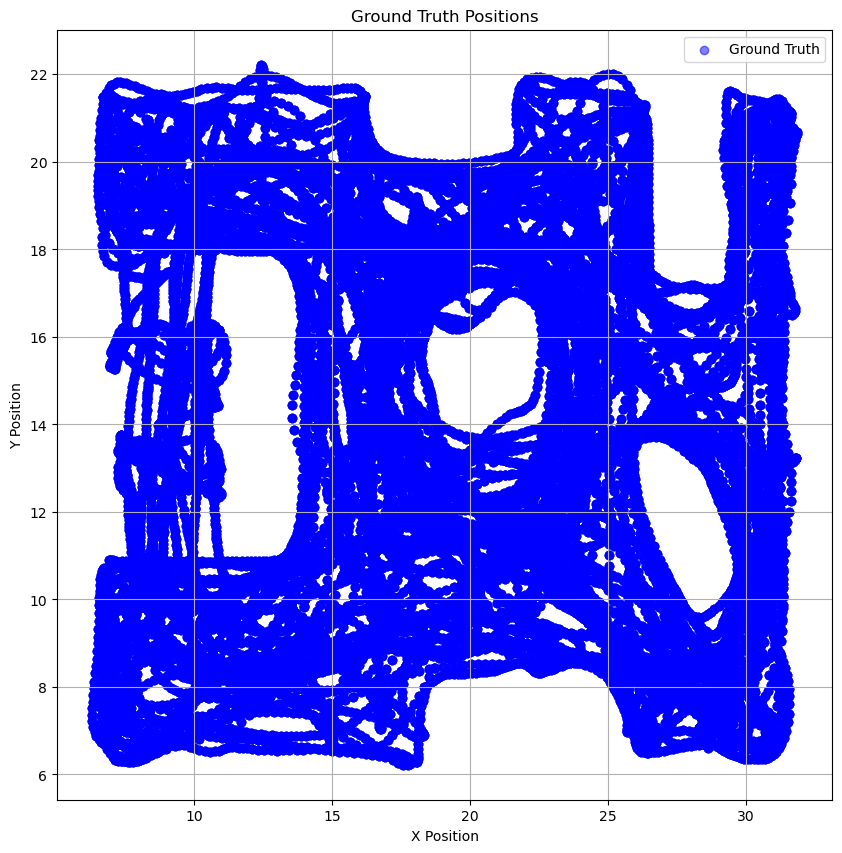

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(grt_pos[:, 0], grt_pos[:, 1], c='blue', label='Ground Truth', alpha=0.5)
plt.title('Ground Truth Positions')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
import numpy as np
from scipy.special import softmax

def build_grid(grid_size=30, space_bounds=None):
    (xmin, xmax), (ymin, ymax) = space_bounds
    x_lin = np.linspace(xmin, xmax, grid_size)
    y_lin = np.linspace(ymin, ymax, grid_size)
        
    xv, yv = np.meshgrid(x_lin, y_lin)
    grid_points = np.stack([xv.ravel(), yv.ravel()], axis=1)
    return grid_points

def compute_soft_probability_maps(positions, grid_points, temperature=.1):
    N = positions.shape[0]
    K = grid_points.shape[0]
    dists = np.linalg.norm(positions[:, np.newaxis, :] - grid_points[np.newaxis, :, :], axis=2)
    sim_scores = -dists / temperature
    prob_maps = softmax(sim_scores, axis=1)
    return prob_maps

def estimate_positions_from_maps(prob_maps, grid_points):
    return np.matmul(prob_maps, grid_points)

def generate_all_probability_maps(positions, grid_size=30, temperature=.1):
    x_min, x_max = positions[:, 0].min(), positions[:, 0].max()
    y_min, y_max = positions[:, 1].min(), positions[:, 1].max()
    print("Position bounds:", (x_min, x_max), (y_min, y_max))
    grid_points = build_grid(grid_size, space_bounds=((x_min, x_max), (y_min, y_max)))
    print("Grid points shape:", grid_points.shape)
    prob_maps = compute_soft_probability_maps(positions, grid_points, temperature=temperature)

    est_locations = estimate_positions_from_maps(prob_maps, grid_points)

    return prob_maps, est_locations, grid_points

In [21]:
def plot_heatmap(prob_map, grid_points, title="Heatmap"):
    plt.figure(figsize=(8, 6))
    plt.imshow(prob_map.reshape(100, 100), extent=(grid_points[:, 0].min(), grid_points[:, 0].max(),
                                                  grid_points[:, 1].min(), grid_points[:, 1].max()),
               origin='lower', cmap='hot', alpha=0.7)
    plt.colorbar(label='Probability')
    plt.title(title)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.show()

In [10]:
prob_map_test, est_locations_test, grid_points_test = generate_all_probability_maps(y_test, grid_size=100, temperature=0.1)
prob_map_train, est_locations_train, grid_points_train = generate_all_probability_maps(y_train, grid_size=100, temperature=0.1)
prob_map_pred, est_locations_pred, grid_points_pred = generate_all_probability_maps(y_pred, grid_size=100, temperature=0.1)

Position bounds: (6.307980483878724, 31.82647141325833) (6.223295579572582, 22.220579267617712)
Grid points shape: (10000, 2)
Position bounds: (6.307980483846373, 31.837173051937405) (6.22329557621037, 22.22057926919299)
Grid points shape: (10000, 2)
Position bounds: (6.307980484593721, 31.837173049773977) (6.223707326117879, 22.220579267647388)
Grid points shape: (10000, 2)


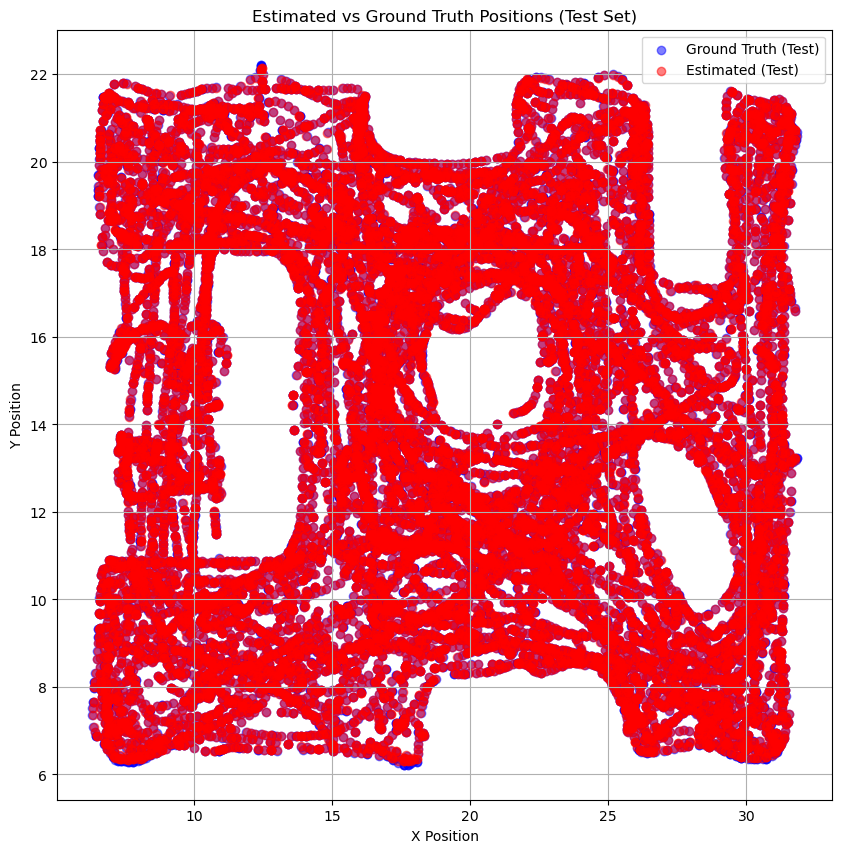

In [11]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test[:, 0], y_test[:, 1], c='blue', label='Ground Truth (Test)', alpha=0.5)
plt.scatter(est_locations_test[:, 0], est_locations_test[:, 1], c='red', label='Estimated (Test)', alpha=0.5)
plt.title('Estimated vs Ground Truth Positions (Test Set)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
from keras import layers
import tensorflow as tf

class NeuralNetwork(tf.keras.Model):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = layers.Dense(2048, input_dim=input_size)
        self.bn1 = layers.BatchNormalization()
        self.fc2 = layers.Dense(1024)
        self.bn2 = layers.BatchNormalization()
        # self.fc3 = layers.Dense(512)
        # self.fc4 = layers.Dense(512)
        # self.fc5 = layers.Dense(512)
        self.fc3 = layers.Dense(output_size, activation='softmax')

    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.bn1(x)
        x = tf.nn.relu(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = tf.nn.relu(x)

        x = self.fc3(x)
        return x

# Set output_size to the number of grid points (e.g., 900 for 30x30 grid)
output_size = grid_points_train.shape[0]  # grid_points from your earlier code
print(output_size)

10000


In [35]:
y_train.shape,X_train.shape

((67921, 2), (67921, 256))

In [ ]:
model=NeuralNetwork(input_size=features_F1_cir.shape[1], output_size=output_size)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, prob_map_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/10


2025-06-11 21:00:22.294210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1697/1698 [============================>.] - ETA: 0s - loss: 8.1530 - accuracy: 0.0271

2025-06-11 21:00:48.783806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1698/1698 [==============================] - 29s 17ms/step - loss: 8.1528 - accuracy: 0.0272 - val_loss: 7.6524 - val_accuracy: 0.0374
Epoch 2/10
1698/1698 [==============================] - 26s 15ms/step - loss: 7.2876 - accuracy: 0.0410 - val_loss: 7.2288 - val_accuracy: 0.0414
Epoch 3/10
1698/1698 [==============================] - 26s 15ms/step - loss: 6.7312 - accuracy: 0.0598 - val_loss: 6.9817 - val_accuracy: 0.0507
Epoch 4/10
1698/1698 [==============================] - 26s 15ms/step - loss: 6.2669 - accuracy: 0.0946 - val_loss: 6.8027 - val_accuracy: 0.0551
Epoch 5/10
1698/1698 [==============================] - 26s 15ms/step - loss: 5.8755 - accuracy: 0.1469 - val_loss: 6.7397 - val_accuracy: 0.0560
Epoch 6/10
1698/1698 [==============================] - 26s 15ms/step - loss: 5.5567 - accuracy: 0.2055 - val_loss: 6.7322 - val_accuracy: 0.0606
Epoch 7/10
1698/1698 [==============================] - 26s 15ms/step - loss: 5.2921 - accuracy: 0.2562 - val_loss: 6.7209 - val_accura

In [37]:
model.fit(X_train, prob_map_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
1698/1698 [==============================] - 30s 17ms/step - loss: 4.6087 - accuracy: 0.3936 - val_loss: 6.7320 - val_accuracy: 0.0654
Epoch 2/30
1698/1698 [==============================] - 26s 15ms/step - loss: 4.4884 - accuracy: 0.4215 - val_loss: 6.7598 - val_accuracy: 0.0642
Epoch 3/30
1698/1698 [==============================] - 26s 15ms/step - loss: 4.3897 - accuracy: 0.4439 - val_loss: 6.7348 - val_accuracy: 0.0637
Epoch 4/30
1698/1698 [==============================] - 26s 15ms/step - loss: 4.3029 - accuracy: 0.4601 - val_loss: 6.7845 - val_accuracy: 0.0678
Epoch 5/30
1698/1698 [==============================] - 26s 15ms/step - loss: 4.2207 - accuracy: 0.4752 - val_loss: 6.7836 - val_accuracy: 0.0674
Epoch 6/30
1698/1698 [==============================] - 26s 15ms/step - loss: 4.1491 - accuracy: 0.4853 - val_loss: 6.7924 - val_accuracy: 0.0598
Epoch 7/30
1698/1698 [==============================] - 26s 15ms/step - loss: 4.0850 - accuracy: 0.5010 - val_loss: 6.8007 -

 37/708 [>.............................] - ETA: 1s

2025-06-11 21:48:33.013411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


708/708 [==============================] - 1s 2ms/step


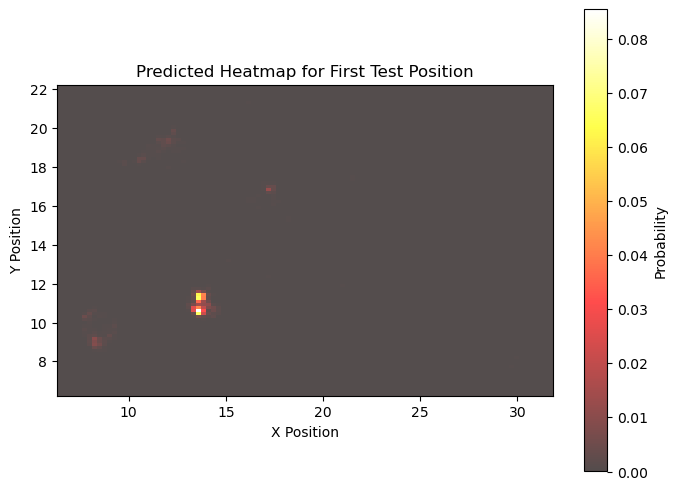

Estimated :- [13.23417325 11.76860844]
Ground Truth :- [13.7296151  10.87717977]


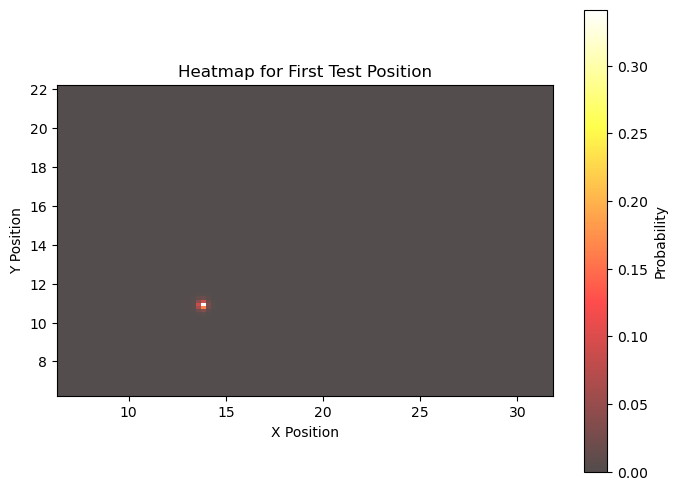

Mean Absolute Error (Position Predictions): [3.16477412 2.19228591]


In [38]:
predicted_maps = model.predict(X_pred)
plot_heatmap(predicted_maps[2], grid_points_pred, title="Predicted Heatmap for First Test Position")
print(f"Estimated :- {estimate_positions_from_maps(predicted_maps, grid_points_pred)[2]}")
print(f"Ground Truth :- {y_pred[2]}")
plot_heatmap(prob_map_pred[2], grid_points_pred, title="Heatmap for First Test Position")
predicted_positions = np.matmul(predicted_maps, grid_points_pred)
mae = np.mean(np.abs(y_pred - predicted_positions), axis=0)
print("Mean Absolute Error (Position Predictions):", mae)

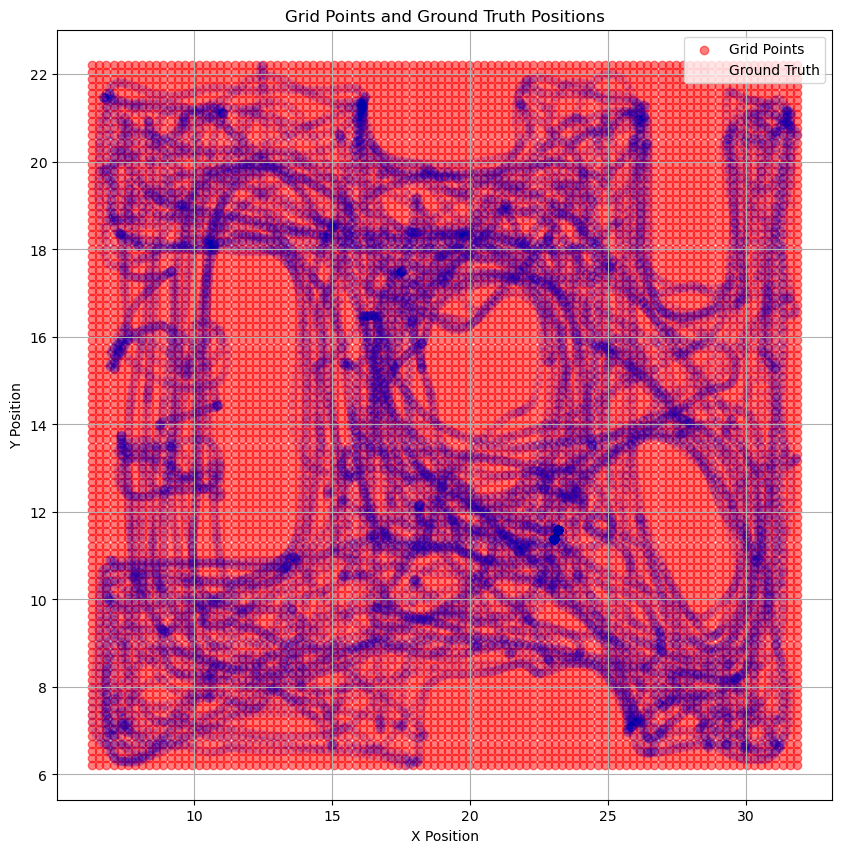

In [26]:
grid_points = build_grid(grid_size=100, space_bounds=((grt_pos[:, 0].min(), grt_pos[:, 0].max()),
                                                    (grt_pos[:, 1].min(), grt_pos[:, 1].max())))
# Plot the grid points
plt.figure(figsize=(10, 10))
plt.scatter(grid_points[:, 0], grid_points[:, 1], c='red', label='Grid Points', alpha=0.5)
plt.scatter(grt_pos[:, 0], grt_pos[:, 1], c='blue', label='Ground Truth', alpha=0.01)
plt.title('Grid Points and Ground Truth Positions')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()